# Réduction de variance
- méthode des variables antithétiques : on posera X=(W[:,0],W[:,1]) et -X=-(W[:,0],W[:,1]) .
Phi est la fonction qui à X=(W[:,0],W[:,1]) associe le prix du call asiatique. ((Pcall)of avec f la fonction qui à X=(W[:,0],W[:,1]) associe le vecteur des prix du sous-jacent noté Prices dans le code) 

- Méthode des variables de contrôle: On se place dans le cadre univarié. On posera X = St et Z = St - mean(St) (St sera noté Prices dans le code correspondant) et Phi est la fonction Pcall (qui à Prices associe le prix du call asiatique). 



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
def Pcall(X):
  return np.maximum(np.mean(X)-K,0)*math.exp(-r*T)




def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths, return_vol=False):

    
    dt = T/steps #Le temps sera discrétisé en steps pas de taille dt, nous avons T=steps*dt
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    antithetic = np.zeros(size)
    S_t = S
    A_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t)*(rho*WT[:,0]+np.sqrt(1-rho**2) *WT[:,1])))
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
        
    
    if return_vol:
        return prices, sigs
   
    return prices




def generate_heston_paths_antithetic(S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths, return_vol=False):

    
    dt = T/steps #Le temps sera discrétisé en steps pas de taille dt, nous avons T=steps*dt
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    antithetic = np.zeros(size)
    S_t = S
    A_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t)*(rho*WT[:,0]+np.sqrt(1-rho**2) *WT[:,1])))
        A_t = A_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t)*(-rho*WT[:,0]-np.sqrt(1-rho**2) *WT[:,1])))
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
        antithetic[:,t] = A_t
    
    if return_vol:
        return prices, sigs, antithetic
   
    return prices, antithetic

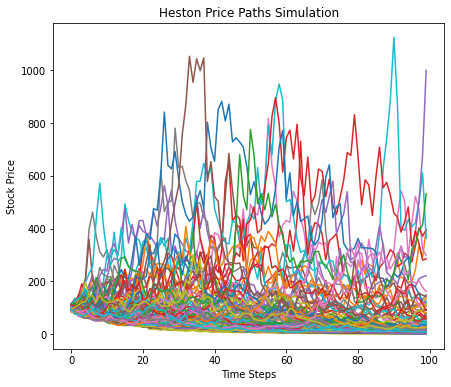

In [17]:
K=50
kappa =2
theta = 0.3
v_0 =  0.04
xi = 0.5
r = 0.03
S = 100
paths = 100
steps = 100
T = 10
rho = 0.2
Prices,sigs,antithetic= generate_heston_paths_antithetic(S, T, r, kappa, theta, v_0, rho, xi, steps, paths,return_vol=True)       
    
plt.figure(figsize=(7,6))
plt.plot(Prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

#plt.clf()
#plt.figure(figsize=(7,6))
#plt.plot(antithetic.T)

#plt.title('Plot variable antithétique')
#plt.xlabel('Time Steps')
#plt.ylabel('A_t')
#plt.legend(fontsize=15)
#plt.show()

# Prix d'un call asiatique par les différentes méthodes (cas avec une seule simulation du prix) (pas indispensable dans les slides, mieux vaut commenter les résultats de la comparaison des variances et du temps de calcul)

In [18]:
print(Pcall(Prices)) #montecarlo classique

31.363875048993055


In [19]:
print((Pcall(Prices)+Pcall(antithetic))/2) # estimation par variables antithétiques

48.31363122115149


In [20]:
Prices_centrée=[]
Pcallvector=[]

for i in range(len(Prices)):
    for j in range(len(Prices[0])):
        Prices_centrée.append(Prices[i][j]-np.mean(Prices[i]))
        Pcallvector.append(Pcall(Prices[j]))

covariance=np.cov(Pcallvector,Prices_centrée)[1][0] 
beta=covariance/np.var(Prices_centrée)
Ccontrol=np.mean(Pcall(Prices)-beta*(np.mean(Prices_centrée)))


print(Ccontrol) # estimation par variables de contrôle


31.363875048993055


# Comparaison des variances

In [7]:
nombre_simulations = 100 

In [11]:
Prix_call_MCclassique=[]
Prix_call_MCantithétique=[]
Prix_call_MCcontrôle=[]
BETA=[]
for i in range(nombre_simulations):
  Prices,sigs,antithetic = generate_heston_paths_antithetic(S, T, r, kappa, theta, v_0, rho, xi, steps, paths,return_vol=True) 
  Prix_call_MCclassique.append(Pcall(Prices))
  Prix_call_MCantithétique.append((Pcall(Prices)+Pcall(antithetic))/2)
  
  Prices_centrée=[]
  Pcallvector=[]

  for i in range(len(Prices)):
      for j in range(len(Prices[0])):
          Prices_centrée.append(Prices[i][j]-np.mean(Prices[i]))
          Pcallvector.append(Pcall(Prices[j]))

  covariance=np.cov(Pcallvector,Prices_centrée)[1][0] 
  beta=covariance/np.var(Prices_centrée)
  Prix_call_MCcontrôle.append(np.mean(Pcall(Prices)-beta*(np.mean(Prices_centrée))))
  BETA.append(beta)

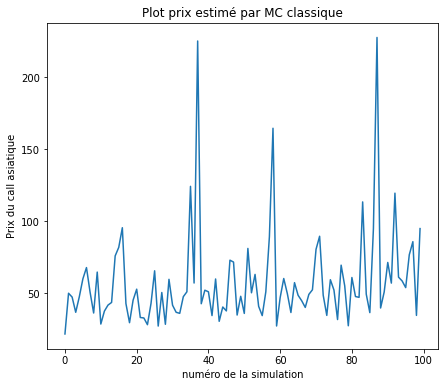

In [12]:
plt.figure(figsize=(7,6))
plt.plot(Prix_call_MCclassique)
plt.title('Plot prix estimé par MC classique')
plt.xlabel('numéro de la simulation')
plt.ylabel('Prix du call asiatique')
plt.show()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

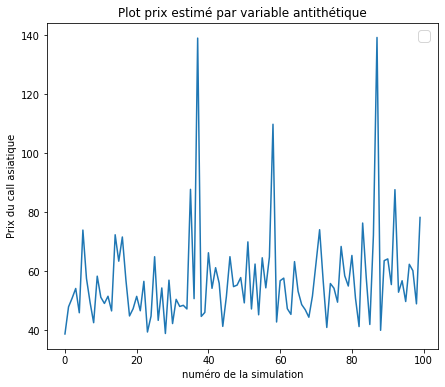

In [13]:
plt.clf()
plt.figure(figsize=(7,6))
plt.plot(Prix_call_MCantithétique)
plt.title('Plot prix estimé par variable antithétique')
plt.xlabel('numéro de la simulation')
plt.ylabel('Prix du call asiatique')
plt.legend(fontsize=15)
plt.show()


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

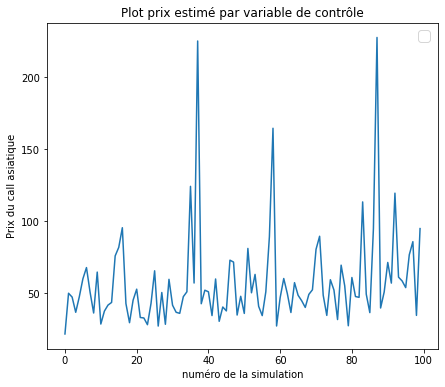

In [14]:
plt.clf()
plt.figure(figsize=(7,6))
plt.plot(Prix_call_MCcontrôle)
plt.title('Plot prix estimé par variable de contrôle')
plt.xlabel('numéro de la simulation')
plt.ylabel('Prix du call asiatique')
plt.legend(fontsize=15)
plt.show()

In [15]:
print('moyenne par la méthode naïve =',np.mean(Prix_call_MCclassique))
print('moyenne par la méthode des variables antithétiques =',np.mean(Prix_call_MCantithétique))
print('moyenne par la méthode des variables de contrôle =',np.mean(Prix_call_MCcontrôle))

moyenne par la méthode naïve = 57.90205133206191
moyenne par la méthode des variables antithétiques = 57.13540486460302
moyenne par la méthode des variables de contrôle = 57.90205133206191


In [16]:
print('variance par la méthode naïve =',np.var(Prix_call_MCclassique))
print('variance par la méthode des variables antithétiques =',np.var(Prix_call_MCantithétique))
print('variance par la méthode des variables de contrôle =',np.var(Prix_call_MCcontrôle))
print('moyenne des beta =',np.mean(BETA))

variance par la méthode naïve = 1109.2037140442285
variance par la méthode des variables antithétiques = 271.77819824629717
variance par la méthode des variables de contrôle = 1109.2037140442285
moyenne des beta = -0.001190757998274884


On remarque que la variance est plus faible en utilisant la méthode des variables antithétiques. 
Explication rapide sur les résultats décevants de la méthode des variables de contrôle: cas univarié et le beta calculé est extrêmement faible (d'où estimation toujours égale à celle de la méthode naïve)

# Comparaison des temps de calcul 

In [21]:
tps1 = time.clock()

Prix_call_MCclassique=[]

for i in range(nombre_simulations):
  Prices,sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, paths,return_vol=True) 
  Prix_call_MCclassique.append(Pcall(Prices))

tps2 = time.clock()

#print(np.mean(Prix_call_MCclassique)) #moyenne des prix par méthode MC classique
print('temps de calcul par MC classique =',tps2-tps1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


temps de calcul par MC classique = 1.6781720000000035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


In [22]:
tps1 = time.clock()

Prix_call_MCantithétique=[]

for i in range(nombre_simulations):
  Prices,sigs,antithetic = generate_heston_paths_antithetic(S, T, r, kappa, theta, v_0, rho, xi, steps, paths,return_vol=True) 
  Prix_call_MCantithétique.append((Pcall(Prices)+Pcall(antithetic))/2)

tps2 = time.clock()

#print(np.mean(Prix_call_MCantithétique)) #moyenne des prix par méthode des variables antithétiques 
print('temps de calcul par la méthode des variables antithétiques =',tps2-tps1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


temps de calcul par la méthode des variables antithétiques = 1.876255999999998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


In [23]:
tps1 = time.clock()

Prix_call_MCcontrôle=[]

for i in range(nombre_simulations):
  Prices,sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, paths,return_vol=True) 
  Prices_centrée=[]
  Pcallvector=[]

  for i in range(len(Prices)):
      for j in range(len(Prices[0])):
          Prices_centrée.append(Prices[i][j]-np.mean(Prices[i]))
          Pcallvector.append(Pcall(Prices[j]))

  covariance=np.cov(Pcallvector,Prices_centrée)[1][0] 
  beta=covariance/np.var(Prices_centrée)
  Prix_call_MCcontrôle.append(np.mean(Pcall(Prices)-beta*(np.mean(Prices_centrée))))

tps2 = time.clock()

#print(np.mean(Prix_call_MCcontrôle)) #moyenne des prix par méthode des variables de contrôle
print('temps de calcul par la méthode des variables de contrôle =',tps2-tps1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


temps de calcul par la méthode des variables de contrôle = 23.688296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
